# 0. Load the data

In [1]:
# builtin
import importlib
# internal
import read_data
import train_model
import params
from tqdm.contrib.concurrent import process_map
# external
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
res_dir = "experiment_result/MBA/"
lgcn_dir = res_dir + "LGCN/"
tri_lgcn_dir = res_dir + "LGCN_tri/"
tri_lgcn_approach_dir = res_dir + "LGCN_tri_approach/"
AB_test_dir = res_dir + "AB_test/"

In [3]:
# load MBA_LGCN_result.json and MBA_LGCN_tri_result.json
with open(AB_test_dir + 'MBA_LGCN_result_sorted_item_name.json', 'r') as f:
    lgcn_res = json.load(f)
with open(AB_test_dir + 'MBA_LGCN_tri_result_sorted_item_name.json', 'r') as f:
    lgcn_tri_res = json.load(f)

In [4]:
len(lgcn_res), len(lgcn_tri_res)

(4207, 4207)

In [5]:
# 把json按user_id的int排序，并检查是否一致
lgcn_res_sorted = {int(k): v for k,v in lgcn_res.items()}
lgcn_tri_res_sorted = {int(k): v for k,v in lgcn_tri_res.items()}
assert sorted(lgcn_res.keys()) == sorted(lgcn_tri_res.keys())

In [6]:
list_empty = []
for i in range(1, 4297):
    if i not in lgcn_res_sorted:
        list_empty.append(i)
# 导入tri_graph_uid2tidx_valid.json，检查list_empty里的user_id在这个json里对应的value是否为空
import json
with open('dataset/MBA/tri_graph_uidx2tidx_valid.json', 'r') as f:
    uid2tidx = json.load(f)
# 检查list_empty里的user_id在uid2tidx里对应的value是否都为空
for i in list_empty:
    assert uid2tidx[str(i)] == []

In [7]:
# load dataset
mba_df = pd.read_csv('dataset/MBA/market.csv', sep=';')
# mba_df = pd.read_csv('../ds/MBA/data.csv', sep=';')
print(mba_df.head())
# clean nan rows
if mba_df.isna().sum().sum() > 0:
    print('all nan eliminated')
    mba_df = mba_df.dropna()
# transfer types
mba_df['BillNo'] = mba_df['BillNo'].astype('int32')
mba_df['Itemname'] = mba_df['Itemname'].astype('string')
mba_df['Quantity'] = mba_df['Quantity'].astype('int32')
mba_df['Date'] = mba_df['Date'].astype('string')
mba_df['Price'] = mba_df['Price'].astype('string')
mba_df['CustomerID'] = mba_df['CustomerID'].astype('int32')

# Identifications
# for user nodes
user_ids = mba_df['CustomerID'].unique()
user_num = len(user_ids)
print(f'totally {user_num} unique users')
user_ids.sort()
user_ids_kv = {}
for ui in range(user_num):
    user_ids_kv[user_ids[ui]] = ui

# for item nodes
item_names = mba_df['Itemname'].unique()
item_num = len(item_names)
print(f'totally {item_num} unique items')
# item_names.sort()
items_kv = {}
for ii in range(item_num):
    items_kv[item_names[ii]] = ii

# for transaction nodes
trans_ids = mba_df['BillNo'].unique()
trans_num = len(trans_ids)
print(f'totally {trans_num} unique transactions')
trans_ids.sort()
trans_kv = {}
for ti in range(trans_num):
    trans_kv[trans_ids[ti]] = ti

# # construct the bi-partite graph
G_user = {} # {uidx: [tidx,]}
G_item = {} # {tidx: [uidx,]}

for index,row in mba_df.iterrows():
    user_index = user_ids_kv[row['CustomerID']]
    item_index = items_kv[row['Itemname']]
    
    # update user side
    if G_user.get(user_index) is None:
        G_user[user_index] = {item_index}
    else:
        G_user[user_index].update([item_index])
    
    # update item side
    if G_item.get(item_index) is None:
        G_item[item_index] = {user_index}
    else:
        G_item[item_index].update([user_index])

assert len(G_item.keys()) == item_num and len(G_user.keys()) == user_num

/var/folders/lh/1l1yxhh50vdcdltw404st9z80000gn/T/ipykernel_47922/2486020301.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  mba_df = pd.read_csv('dataset/MBA/market.csv', sep=';')


   BillNo                             Itemname  Quantity              Date  \
0  536365   WHITE HANGING HEART T-LIGHT HOLDER         6  01.12.2010 08:26   
1  536365                  WHITE METAL LANTERN         6  01.12.2010 08:26   
2  536365       CREAM CUPID HEARTS COAT HANGER         8  01.12.2010 08:26   
3  536365  KNITTED UNION FLAG HOT WATER BOTTLE         6  01.12.2010 08:26   
4  536365       RED WOOLLY HOTTIE WHITE HEART.         6  01.12.2010 08:26   

  Price  CustomerID         Country  
0  2,55     17850.0  United Kingdom  
1  3,39     17850.0  United Kingdom  
2  2,75     17850.0  United Kingdom  
3  3,39     17850.0  United Kingdom  
4  3,39     17850.0  United Kingdom  
all nan eliminated
totally 4297 unique users
totally 3846 unique items
totally 18163 unique transactions


In [8]:
item_names[1]

'WHITE METAL LANTERN'

In [9]:
persona2idx_whole = {'Kitchen and Culinary Enthusiast': 0,
 'Home Decor Aficionado': 1,
 'Vintage and Retro Enthusiast': 2,
 'Seasonal and Festive Decorator': 3,
 'Crafting and DIY Hobbyist': 4,
 'Baking and Confectionery Fans': 5,
 'Child and Family-centric Shopper': 6,
 'Collector of Unique and Novelty Items': 7,
 'Comfort and Coziness Seeker': 8,
 'Gardening Lover': 9,
 'Tea and Coffee Lover': 10,
 'Educational and Learning Driven': 11,
 'Stationery and Organization Enthusiast': 12,
 'Eco-friendly and Sustainable Goods Supporter': 13,
 'Party and Event Planners': 14,
 'Outdoor and Adventure Prep': 15,
 'Fashion Forward and Accessory Savvy': 16,
 'Art and Design Admirers': 17,
 'Animal and Pet Advocates': 18,
 'Health and Wellness Focus': 19}

In [10]:
# 读入tri_graph_uidx2pidx.json，以便知道每个user被assign了哪些persona
with open('dataset/MBA/tri_graph_uidx2pidx.json', 'r') as f:
    uid2pidx = json.load(f)
# 按user_id排序
uid2pidx_sorted = {int(k): v for k,v in uid2pidx.items()}

# 再读入tri_graph_tidx2pidx.json，以便知道每个item有哪些persona
with open('dataset/MBA/tri_graph_tidx2pidx.json', 'r') as f:
    tidx2pidx = json.load(f)
# 按item_id排序
tidx2pidx_sorted = {int(k): v for k,v in tidx2pidx.items()}

In [11]:
len(uid2pidx), len(tidx2pidx), len(uid2pidx_sorted), len(tidx2pidx_sorted)

(4286, 3846, 4286, 3846)

In [12]:
uid2pidx_sorted[4296]

[3, 7, 8]

# 1. Process data -> dataframe

In [13]:
# 开始建立一个dataframe，涉及的列有：user_id, user_persona, user_persona_number, purchased_item_name

# 1. user_id
user_id = []
for i in range(1, 4297):
    user_id.append(i)

# 2. user_persona and length
user_persona = []
user_persona_number = []
for i in range(1, 4297):
    if i in uid2pidx_sorted:
        user_persona.append(uid2pidx_sorted[i])
        user_persona_number.append(len(uid2pidx_sorted[i]))
    else:
        user_persona.append([])
        user_persona_number.append(0)

# 4. purchased_item_name and length
purchased_item_name = []
purchased_item_length = []
for i in range(1, 4297):
    if i in lgcn_res_sorted:
        purchased_item_name.append(lgcn_res_sorted[i][1])
        purchased_item_length.append(len(lgcn_res_sorted[i][1]))
    else:
        purchased_item_name.append([])
        purchased_item_length.append(0)

# 5. LGCN recommend item name, should get from lgcn_res_sorted
lgcn_recomm_item_name = []
for i in range(1, 4297):
    if i in lgcn_res_sorted:
        lgcn_recomm_item_name.append(lgcn_res_sorted[i][2])
    else:
        lgcn_recomm_item_name.append([])

# 6. LGCN_tri recommend item name, should get from lgcn_tri_res_sorted
lgcn_tri_recomm_item_name = []
for i in range(1, 4297):
    if i in lgcn_tri_res_sorted:
        lgcn_tri_recomm_item_name.append(lgcn_tri_res_sorted[i][2])
    else:
        lgcn_tri_recomm_item_name.append([])

# create dataframe
df = pd.DataFrame({'user_id': user_id, 'user_persona': user_persona, 'user_persona_number': user_persona_number, 
                   'purchased_item_name': purchased_item_name, 'purchased_item_length': purchased_item_length,
                   'lgcn_recomm_item_name': lgcn_recomm_item_name, 'lgcn_tri_recomm_item_name': lgcn_tri_recomm_item_name})
                   
df = df[df['purchased_item_length'] != 0]
print(len(df))
df.tail(100)

4207


,user_id,user_persona,user_persona_number,purchased_item_name,purchased_item_length,lgcn_recomm_item_name,lgcn_tri_recomm_item_name
4191,4192,"[5, 10, 2]",3,"[PACK OF 60 SPACEBOY CAKE CASES, PAPER BUNTING...",2,"[PACK OF 60 PINK PAISLEY CAKE CASES, EDWARDIAN...","[PACK OF 60 PINK PAISLEY CAKE CASES, 72 SWEETH..."
4192,4193,"[2, 3]",2,"[ENGLISH ROSE GARDEN SECATEURS, VINTAGE BEAD P...",2,"[FAIRY CAKE FLANNEL ASSORTED COLOUR, HOMEMADE ...","[PINK POLKADOT WRAP, BLUE POLKADOT WRAP, PACK ..."
4193,4194,"[7, 9, 15]",3,"[PARTY BUNTING, HEART FILIGREE DOVE LARGE, WHI...",3,"[JUMBO BAG BAROQUE BLACK WHITE, JUMBO BAG PIN...","[JUMBO BAG BAROQUE BLACK WHITE, JUMBO BAG PIN..."
4194,4195,"[3, 4, 6]",3,"[RED FLORAL FELTCRAFT SHOULDER BAG, PINK BLUE ...",6,"[RED FLORAL FELTCRAFT SHOULDER BAG, PINK BLUE ...","[RED FLORAL FELTCRAFT SHOULDER BAG, PINK BLUE ..."
4195,4196,"[3, 5, 7, 6]",4,"[SET OF 4 PANTRY JELLY MOULDS, JAM CLOCK MAGNE...",8,"[EDWARDIAN PARASOL RED, EDWARDIAN PARASOL BLAC...","[SET 3 PAPER VINTAGE CHICK PAPER EGG, EASTER T..."
...,...,...,...,...,...,...,...
4291,4292,"[2, 10, 7]",3,"[GUMBALL COAT RACK, WOODEN UNION JACK BUNTING]",2,"[ENAMEL FLOWER JUG CREAM, ALARM CLOCK BAKELIKE...","[ALARM CLOCK BAKELIKE GREEN, ALARM CLOCK BAKEL..."
4292,4293,[6],1,"[CARD CIRCUS PARADE, ROBOT BIRTHDAY CARD]",2,"[SPACEBOY BIRTHDAY CARD, DOLLY GIRL LUNCH BOX,...","[DOLLY GIRL LUNCH BOX, LOVE SEAT ANTIQUE WHITE..."
4293,4294,"[2, 0, 5]",3,"[SET OF 12 MINI LOAF BAKING CASES, PAPER BUNTI...",3,"[PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...","[SWISS ROLL TOWEL, CHOCOLATE SPOTS, REGENCY T..."
4294,4295,"[6, 8, 4, 3, 2, 7, 0, 12]",8,"[6 GIFT TAGS VINTAGE CHRISTMAS, VINTAGE DOILY ...",55,"[LUNCH BAG SPACEBOY DESIGN, 60 TEATIME FAIRY C...","[LUNCH BAG SPACEBOY DESIGN, 60 TEATIME FAIRY C..."


# 2. Calculate the F1_score and compare the improvement

In [14]:
def calculate_F1_score(row, k):
    purchased_item_name = row['purchased_item_name']
    lgcn_recomm_item_name_topk = row['lgcn_recomm_item_name'][:k]
    lgcn_tri_recomm_item_name_topk = row['lgcn_tri_recomm_item_name'][:k]

    # calculate F1_score for LGCN
    intersection = len(set(purchased_item_name) & set(lgcn_recomm_item_name_topk))
    precision = intersection / len(lgcn_recomm_item_name_topk)
    recall = intersection / len(purchased_item_name)
    if intersection == 0:
        F1_score_lgcn = 0
    else:
        F1_score_lgcn = 2 * precision * recall / (precision + recall)

    # calculate F1_score for LGCN_tri
    intersection = len(set(purchased_item_name) & set(lgcn_tri_recomm_item_name_topk))
    precision = intersection / len(lgcn_tri_recomm_item_name_topk)
    recall = intersection / len(purchased_item_name)
    if intersection == 0:
        F1_score_lgcn_tri = 0
    else:
        F1_score_lgcn_tri = 2 * precision * recall / (precision + recall)

    return F1_score_lgcn, F1_score_lgcn_tri

In [15]:
def calculate_average_F1_scores(df, k):
    F1_score_lgcn = []
    F1_score_lgcn_tri = []
    for i in range(len(df)):
        F1_score_lgcn_i, F1_score_lgcn_tri_i = calculate_F1_score(df.iloc[i], k)
        F1_score_lgcn.append(F1_score_lgcn_i)
        F1_score_lgcn_tri.append(F1_score_lgcn_tri_i)
    
    avg_F1_score_lgcn = np.mean(F1_score_lgcn)
    avg_F1_score_lgcn_tri = np.mean(F1_score_lgcn_tri)
    
    print(f'Average Recommendation Top@{k}: F1_score for LGCN: {avg_F1_score_lgcn}, F1_score for LGCN_tri: {avg_F1_score_lgcn_tri}, improvement: {avg_F1_score_lgcn_tri - avg_F1_score_lgcn}')
    
    # return avg_F1_score_lgcn, avg_F1_score_lgcn_tri


In [16]:
calculate_average_F1_scores(df, 10)
calculate_average_F1_scores(df, 20)

Average Recommendation Top@10: F1_score for LGCN: 0.11284021155755343, F1_score for LGCN_tri: 0.1238720645869973, improvement: 0.011031853029443872
Average Recommendation Top@20: F1_score for LGCN: 0.11463778965688831, F1_score for LGCN_tri: 0.12364034335111102, improvement: 0.009002553694222704


# 3. Ablation study a: select the top personalized user and compare

In [54]:
# from df, select the users who have been assigned the most persona (say top 100 users)
df_top100 = df.sort_values(by='user_persona_number', ascending=False).head(100)
df_bottom100 = df.sort_values(by='user_persona_number', ascending=True).head(100)

In [55]:
calculate_average_F1_scores(df_top100, 20)
calculate_average_F1_scores(df, 20)
calculate_average_F1_scores(df_bottom100, 20)

Average Recommendation Top@20: F1_score for LGCN: 0.14070133522880146, F1_score for LGCN_tri: 0.1408401526855433, improvement: 0.00013881745674185209
Average Recommendation Top@20: F1_score for LGCN: 0.11463778965688831, F1_score for LGCN_tri: 0.12364034335111102, improvement: 0.009002553694222704
Average Recommendation Top@20: F1_score for LGCN: 0.06579215132693393, F1_score for LGCN_tri: 0.06868552606813477, improvement: 0.002893374741200841


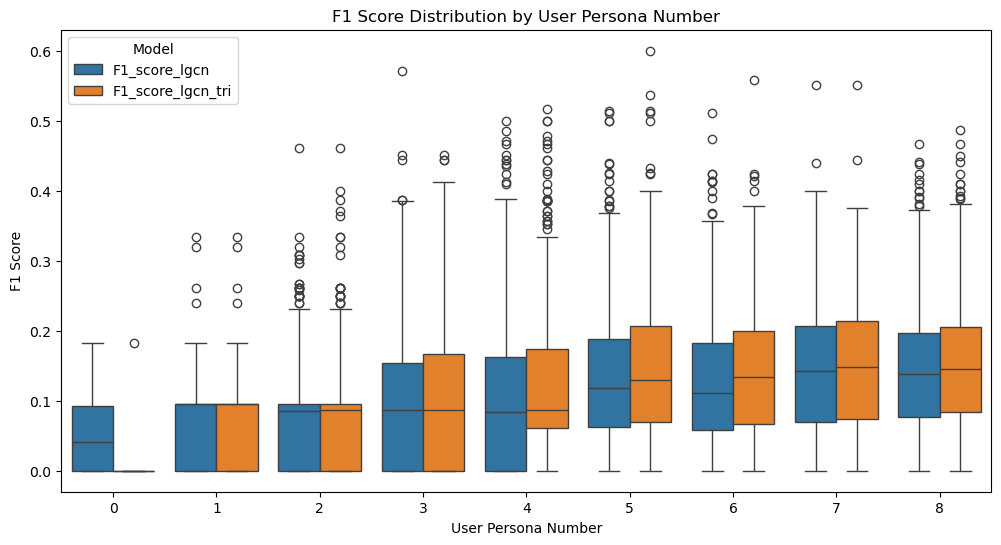

In [ ]:
def calculate_F1_scores(df, k):
    F1_scores = []
    for i in range(len(df)):
        F1_score_lgcn_i, F1_score_lgcn_tri_i = calculate_F1_score(df.iloc[i], k)
        F1_scores.append({
            'user_persona_number': df.iloc[i]['user_persona_number'],
            'F1_score_lgcn': F1_score_lgcn_i,
            'F1_score_lgcn_tri': F1_score_lgcn_tri_i
        })
    
    return pd.DataFrame(F1_scores)

# 计算 F1 分数
F1_scores_df = calculate_F1_scores(df, 20)

# 将数据转换为长格式以便于绘图
F1_scores_long_df = pd.melt(F1_scores_df, id_vars=['user_persona_number'], 
                            value_vars=['F1_score_lgcn', 'F1_score_lgcn_tri'], 
                            var_name='Model', value_name='F1_score')

plt.figure(figsize=(12, 6))
sns.boxplot(x='user_persona_number', y='F1_score', hue='Model', data=F1_scores_long_df)
plt.xlabel('User Persona Number')
plt.ylabel('F1 Score')
plt.title('F1 Score Distribution by User Persona Number')
plt.legend(title='Model')
plt.show()

# 4. Ablation study b: select the users purchased most products

In [56]:
df_purchased_top100 = df.sort_values(by='purchased_item_length', ascending=False).head(100)
df_purchased_bottom100 = df.sort_values(by='purchased_item_length', ascending=True).head(100)


In [81]:
calculate_average_F1_scores(df_purchased_top100, 50)
calculate_average_F1_scores(df, 50)
calculate_average_F1_scores(df_purchased_bottom100, 50)

Average Recommendation Top@50: F1_score for LGCN: 0.2308701244043628, F1_score for LGCN_tri: 0.2337185651398549, improvement: 0.0028484407354920915
Average Recommendation Top@50: F1_score for LGCN: 0.10075473146978633, F1_score for LGCN_tri: 0.1066181739655556, improvement: 0.005863442495769269
Average Recommendation Top@50: F1_score for LGCN: 0.0196078431372549, F1_score for LGCN_tri: 0.020392156862745096, improvement: 0.000784313725490194


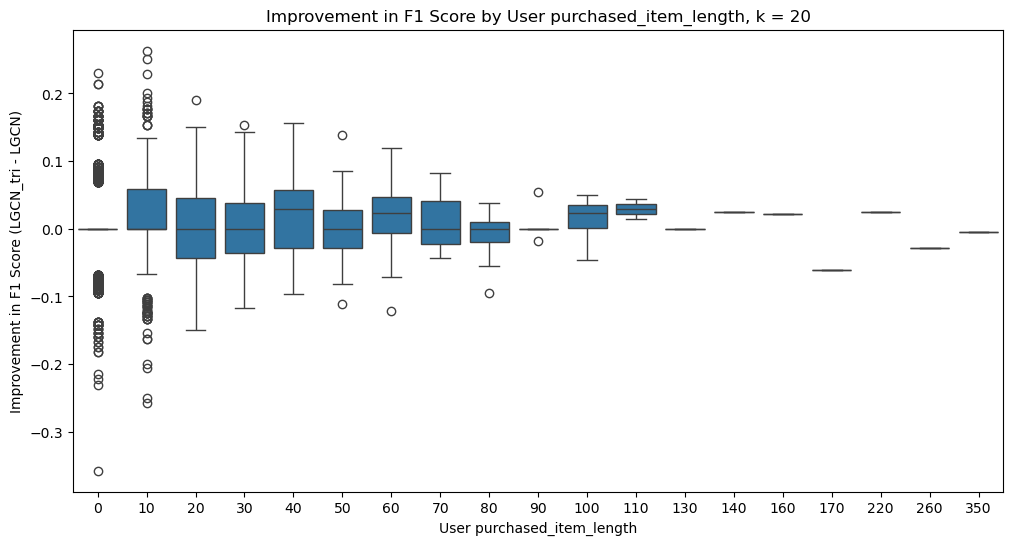

In [82]:
def calculate_F1_scores(df, k):
    improvements = []
    for i in range(len(df)):
        F1_score_lgcn_i, F1_score_lgcn_tri_i = calculate_F1_score(df.iloc[i], k)
        improvement = F1_score_lgcn_tri_i - F1_score_lgcn_i
        improvements.append({
            'purchased_item_length': df.iloc[i]['purchased_item_length'],
            'improvement': improvement
        })
    
    return pd.DataFrame(improvements)

# 计算 F1 分数的改进
improvements_df = calculate_F1_scores(df, 20)

# 将 purchased_item_length 按每 10 个区间分组
improvements_df['purchased_item_length'] = (improvements_df['purchased_item_length'] // 10) * 10

# 绘制 boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='purchased_item_length', y='improvement', data=improvements_df)
plt.xlabel('User purchased_item_length')
plt.ylabel('Improvement in F1 Score (LGCN_tri - LGCN)')
plt.title('Improvement in F1 Score by User purchased_item_length, k = 20')
plt.show()

# 5. Ablation Study c: for each persona, how much performance inc it brings

In [19]:
def calculate_F1_scores(df, k):
    improvements = []
    for i in range(len(df)):
        F1_score_lgcn_i, F1_score_lgcn_tri_i = calculate_F1_score(df.iloc[i], k)
        improvement = F1_score_lgcn_tri_i - F1_score_lgcn_i
        improvements.append({
            'user_id': df.iloc[i]['user_id'],
            'user_persona': df.iloc[i]['user_persona'],
            'improvement': improvement
        })
    
    return pd.DataFrame(improvements)

F1_scores_df = calculate_F1_scores(df, 50)

# 统计每个 persona 出现在多少个用户上，并计算有这个 persona 的用户的平均 F1 分数提升
persona_stats = {i: {'user_count': 0, 'total_improvement': 0} for i in range(20)}

for _, row in F1_scores_df.iterrows():
    for persona in row['user_persona']:
        persona_stats[persona]['user_count'] += 1
        persona_stats[persona]['total_improvement'] += row['improvement']

# 计算平均 F1 分数提升
for persona in persona_stats:
    if persona_stats[persona]['user_count'] > 0:
        persona_stats[persona]['average_improvement'] = persona_stats[persona]['total_improvement'] / persona_stats[persona]['user_count']
    else:
        persona_stats[persona]['average_improvement'] = 0

# 按照user_count排序，打印结果
sorted_persona_stats = sorted(persona_stats.items(), key=lambda x: x[1]['user_count'], reverse=True)
for persona, stats in sorted_persona_stats:
    print(f'Persona: {persona}, User Count: {stats["user_count"]}, Average Improvement: {stats["average_improvement"]}')

# 保存为表格，也是按照 user_count 排序
persona_stats_df = pd.DataFrame(sorted_persona_stats, columns=['persona', 'stats'])
persona_stats_df['user_count'] = persona_stats_df['stats'].apply(lambda x: x['user_count'])
persona_stats_df['average_improvement'] = persona_stats_df['stats'].apply(lambda x: x['average_improvement'])
persona_stats_df.drop(columns=['stats'], inplace=True)


Persona: 2, User Count: 2903, Average Improvement: 0.006440882144071407
Persona: 3, User Count: 2886, Average Improvement: 0.006123150877348461
Persona: 7, User Count: 2494, Average Improvement: 0.006009292881913271
Persona: 1, User Count: 2135, Average Improvement: 0.005082491114538766
Persona: 4, User Count: 1819, Average Improvement: 0.006614224636433482
Persona: 8, User Count: 1467, Average Improvement: 0.005472981413307195
Persona: 6, User Count: 1261, Average Improvement: 0.008284672831504086
Persona: 9, User Count: 1184, Average Improvement: 0.005901441458612488
Persona: 5, User Count: 1175, Average Improvement: 0.007929376232902647
Persona: 0, User Count: 907, Average Improvement: 0.006288109295051787
Persona: 14, User Count: 745, Average Improvement: 0.007267953857508565
Persona: 10, User Count: 546, Average Improvement: 0.004073369924038654
Persona: 12, User Count: 322, Average Improvement: 0.007297962767373256
Persona: 17, User Count: 113, Average Improvement: 0.004465060559

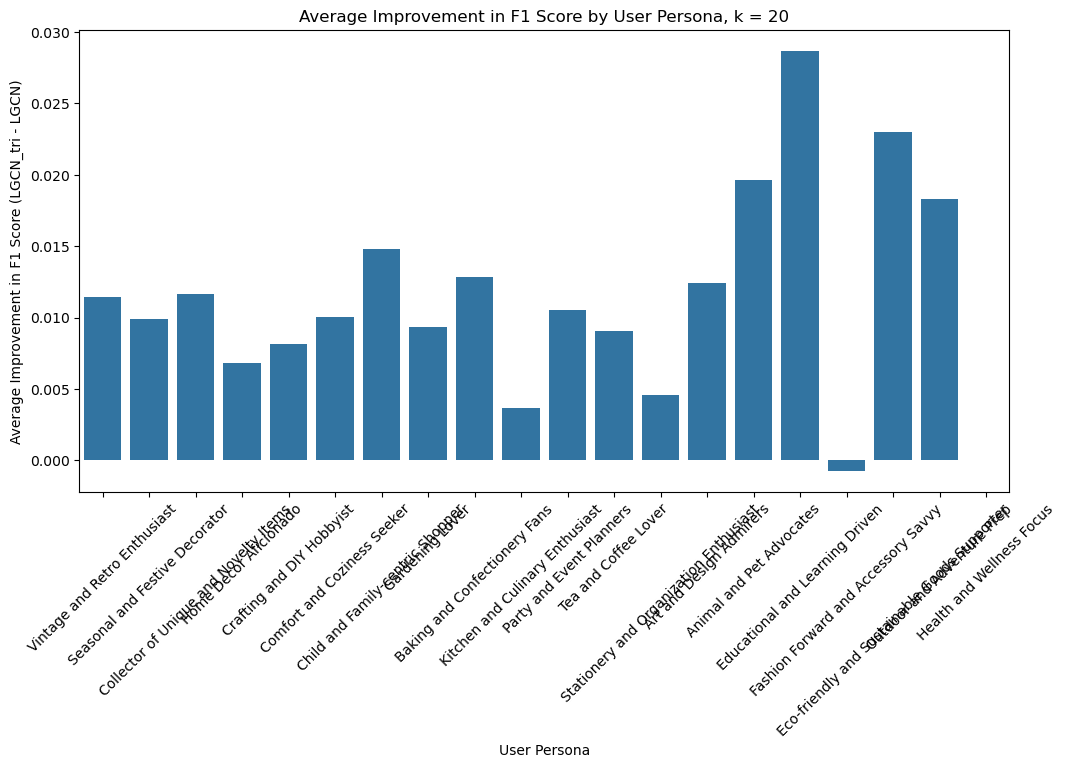

In [131]:
# use this result to draw a bar plot, change the x-axis to persona name
# rank them by their persona user count in descending order, the persona occurs in more users should be on the left
persona_stats_df['persona'] = persona_stats_df['persona'].map(lambda x: list(persona2idx_whole.keys())[x])
persona_stats_df.sort_values(by='user_count', ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(x='persona', y='average_improvement', data=persona_stats_df)
plt.xticks(rotation=45)
plt.xlabel('User Persona')
plt.ylabel('Average Improvement in F1 Score (LGCN_tri - LGCN)')
plt.title('Average Improvement in F1 Score by User Persona, k = 20')
plt.show()
